In [1]:
# This notebook performs a statistical analysis on the learning rates between two groups of mice,
# and generates publication-ready figures. It is split in 3 parts:

# 1. Load requirements and basic exploration of the data
# 2. Model fitting of individual mice, comparison of parameters
#    and import of lesion data for each mouse from image analysis to remove individual mice from the study
# 3. Statistical analysis between the groups to conclude differences and points of divergence in learning

In [17]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf
import os
import sys
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
#from itertools import chains
from scipy import stats
import scipy.optimize as opt
import random
from IPython.display import clear_output
from datetime import date
import pingouin as pg
from sklearn.linear_model import LinearRegression
import dill
from itertools import chain
clear_output()

In [90]:

# 6OHDA_Apr2020 Dataset name
DS_name = '6OHDA_Apr2020' # This dataset has been pre-processed, but conditions have not been selected
hue_order = ['CortexBuffer', '6OHDAtail']
LSpalette = [(0.24715576, 0.49918708, 0.57655991), (0.72162039, 0.3669119 , 0.22526315)]
sns.set_palette(LSpalette)

# remove some animals from the first cohort
ans_to_remove = ['C04', 'C05', 'C06', 'N06']

# remove sessions if needed
sessions_to_remove = []

clear_output()

In [4]:
"""
# D1KO_PreTraining_May2020
DS_name = 'D1KO_PreTraining_May2020' # This dataset has been pre-processed, but conditions have not been selected
hue_order = ['CortexBuffer', 'D1cre']
LSpalette = [(0.24715576, 0.49918708, 0.57655991), (142/255, 160/255 , 11/255)]
sns.set_palette(LSpalette)

# animals to remove from the dataset
ans_to_remove = ['C01', 'C02', 'C03', 'SomFlp04', 'SomFlp06']

# OPTIONAL: remove sessions
# DRD103 session where probably there was no proper water calibration or something like that
sessions_to_remove = ['DRD103 Aug28 14:55']
"""
clear_output()

In [80]:
"""
# D2-caspase_controls-lesion_Apr2021
DS_name = 'D2-caspase_controls-lesion_Apr2021' # This dataset has been pre-processed, but conditions have not been selected
hue_order = ['6OHDA-controls', 'lesion']
LSpalette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
sns.set_palette(LSpalette)

# animals to remove from the dataset
ans_to_remove = []

# OPTIONAL: remove sessions
# DRD103 session where probably there was no proper water calibration or something like that
sessions_to_remove = []
"""

In [6]:
print('Analyzing', DS_name)

Analyzing D2-caspase_controls-lesion_Apr2021


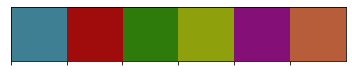

In [7]:
# set a color palette https://xkcd.com/color/rgb/
"""
hmv_palette = ['#380282', '#c04e01']
sns.set_palette(hmv_palette)
sns.palplot(sns.color_palette())
"""
sns.palplot([(0.24715576, 0.49918708, 0.57655991),
             (160/255, 11/255 , 11/255),
             (46/255, 122/255 , 11/255),
             (142/255, 160/255 , 11/255),
             (132/255, 15/255 , 118/255),
             (0.72162039, 0.3669119 , 0.22526315),
            ])
clear_output()

In [91]:
# path to the dataset
data_directory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/' + DS_name + '_Analysis/'
# dataframe name
df_name = DS_name + '_dataframe.pkl'

# Read the dataframe
df_to_plot = pd.read_pickle(data_directory + df_name)

# Print output for report
print('Date of analysis:', date.today())
print('Output folder:', data_directory)

Date of analysis: 2021-05-19
Output folder: /home/hernandom/data/Behavioural_Data/Bpod_data/6OHDA_Apr2020_Analysis/


In [94]:
if os.path.isfile(data_directory + DS_name + '.db'):
    dill.load_session(data_directory + DS_name + '.db')
    print('workspace loaded')

In [95]:
# remove some animals
df_to_plot = df_to_plot[~df_to_plot.AnimalID.isin(ans_to_remove)]
print('Animals in dataset:', df_to_plot.AnimalID.unique())

Animals in dataset: ['C01' 'C02' 'C03' 'PV01' 'PV02' 'PV03' 'PV04' 'PV05' 'PV06' 'SomFlp04'
 'SomFlp06' 'SomFlp07' 'SomFlp08' 'SomFlp09' 'PV08']


In [96]:
# Select only the auditory for now
protocols_selected = ['Auditory']
df_to_plot = df_to_plot[df_to_plot.Protocol.isin(protocols_selected)]
print('Protocols selected:', protocols_selected)

Protocols selected: ['Auditory']


In [12]:
#np.unique(df_to_plot.Contingency, return_counts=True)

In [97]:
# Remove change of contingency if any
cont_to_remove = 2
df_to_plot = df_to_plot[df_to_plot['Contingency'] != cont_to_remove]

In [98]:
# select trials up to a certain number
trials_up_to = 5000
df_to_plot = df_to_plot[df_to_plot['CumulativeTrialNumberByProtocol'] < trials_up_to]
print('Selection of trials less than ', trials_up_to)

Selection of trials less than  5000


In [99]:
# removal of the first trials of each session
tr_beginning = 5
df_to_plot = df_to_plot[df_to_plot['TrialIndex'] > tr_beginning]
print('Removal of the first', tr_beginning, 'trials of each session')

Removal of the first 5 trials of each session


In [100]:
# substitute nans by 0s in firstpokecorrect as otherwise are not counted for the performance
df_to_plot['FirstPokeCorrect'] = df_to_plot['FirstPokeCorrect'].fillna(value=0)

In [101]:
# maximum number of trials performed per mouse in the dataset:
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumberByProtocol']

AnimalID  ExperimentalGroup  Protocol
C01       CortexBuffer       Auditory    4999.0
C02       CortexBuffer       Auditory    4999.0
C03       CortexBuffer       Auditory    4999.0
PV01      6OHDAtail          Auditory    4999.0
PV02      6OHDAtail          Auditory    4999.0
PV03      6OHDAtail          Auditory    4999.0
PV04      6OHDAtail          Auditory    4999.0
PV05      6OHDAtail          Auditory    4999.0
PV06      6OHDAtail          Auditory    4999.0
PV08      6OHDAtail          Auditory    4999.0
SomFlp04  CortexBuffer       Auditory    4953.0
SomFlp06  CortexBuffer       Auditory    4999.0
SomFlp07  6OHDAtail          Auditory    4999.0
SomFlp08  6OHDAtail          Auditory    4999.0
SomFlp09  6OHDAtail          Auditory    4999.0
Name: CumulativeTrialNumberByProtocol, dtype: float64

#### Performance by session and 200-sized bins 

In [18]:
# bin trials every 200
df_to_plot["TrialIndexBinned200"] = (df_to_plot.CumulativeTrialNumberByProtocol // 200) * 200 + 100

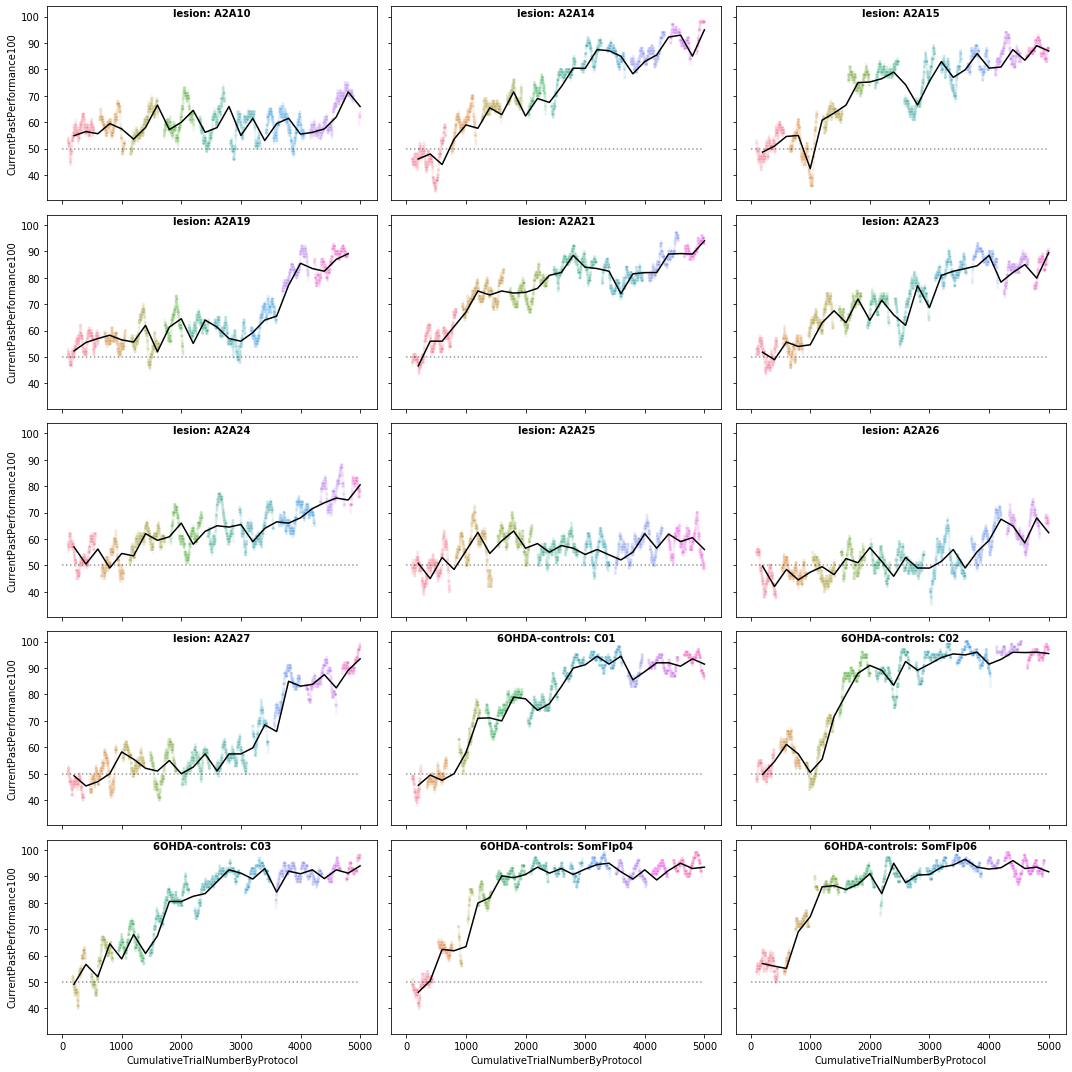

In [19]:
# Sanity check on the data to see that it looks good
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    
    # plot here
    sns.scatterplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # plot a line for binned trials
    sns.lineplot(x=df_to_plot[df_to_plot.AnimalID == animal]["TrialIndexBinned200"] + 100, #trick to align as
                 #CurrentPastPerformance looks at the past 
                 y=100 * df_to_plot[df_to_plot.AnimalID == animal]["FirstPokeCorrect"],
                 color='k',
                 ci=None,
                 ax=ax)
    
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
update_progress(1)
plt.savefig(data_directory + 'Performance_by_session_individual_animals.pdf', transparent=True, bbox_inches='tight')
clear_output()
plt.show(fig)

Colored dots show the performance of the past 100 trials using an average running window. Each color represents a distinct session. The black line shows the performance value of the past 200 trials using trial bining.

In [20]:
# remove sessions
df_to_plot = df_to_plot[~df_to_plot.SessionID.isin(sessions_to_remove)]
print('Sessions removed from dataset:', sessions_to_remove)

Sessions removed from dataset: []


#### Fit a sigmoid to every mouse to calculate and compare stages and learning rates

In [21]:
#calculate the maximum performance for every mouse based on the trials binned every 200
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200','Protocol']).median().reset_index()
mouse_max_perf = df_bin200tr.groupby('AnimalID').max().reset_index()[['AnimalID', 'CurrentPastPerformance100']]

In [22]:
def sigmoid_func(x, perf_end, slope, bias): 
    return (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5 

The sigmoid function is (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5

Data is scaled before the fitting and parameters are rescaled afterwards

The maximum performace possible is defined as the maximum of the median of the trials binned every 200 

In [23]:
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
# create a diccionary to store the results, and lists to rescale the data
fit_dir = {}
xmeans_list = []
xsd_list = []

# process data from all animals
for counter, animal in enumerate(ans_list):
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # calculate and plot the fitting
    xdata = np.array(df.CumulativeTrialNumberByProtocol)
    ydata = np.array(df.CurrentPastPerformance100)
    
    # scale the data
    xdatasc = (xdata - xdata.mean()) / xdata.std()
    ydatasc = ydata / 100
    
    # limit to the maximum performance for this mouse:
    mp = mouse_max_perf[mouse_max_perf.AnimalID==animal].CurrentPastPerformance100.iloc[0] / 100

    cost_func = lambda x: np.mean(np.abs(sigmoid_func(xdatasc, x[0], x[1], x[2]) - ydatasc))
    res = opt.minimize(cost_func, [1, 0, 0], bounds=((0.5, mp), (0., 10.), (None,None)))

    update_progress(counter / num_ans)
    
    #update dicctionary and lists
    fit_dir[animal] = res
    xmeans_list.append(xdata.mean())
    xsd_list.append(xdata.std())
    
clear_output()

In [24]:
#optional
for key, value in fit_dir.items():
    print(key,  '  ', value.x)
clear_output()

In [25]:
# convert to dataframe
fit_df = pd.DataFrame({
    'AnimalID': list(fit_dir.keys()),
    'maximum_performance': [v.x[0] for k, v in fit_dir.items()],
    'slope': [v.x[1] for k, v in fit_dir.items()],
    'bias': [v.x[2] for k, v in fit_dir.items()]
})
# get the Experimental procedure
fit_df['ExperimentalGroup'] = fit_df['AnimalID'].apply(
        lambda x: df_to_plot[df_to_plot.AnimalID==x].ExperimentalGroup.unique()[0]
    )
# rescale back the coefficients
fit_df.maximum_performance = fit_df.maximum_performance * 100
fit_df.slope = fit_df.slope / np.array(xsd_list)
fit_df.bias = fit_df.bias * np.array(xsd_list) + np.array(xmeans_list)

In [26]:
#fit_df

In [27]:
#### explore another way of calculating the learning rate (e.g. maximum of the derivative)
#and the bias (e.g. learning period extracted from percentages of the sigmoid)

In [28]:
# sigmoid function scaled
def sigmoid_func_sc(x, perf_end, slope, bias): 
    return (perf_end - 50) / (1 + np.exp(-slope * (x - bias))) + 50

In [29]:
# derivative function
def der_sig(x, perf_end, slope, bias):
    return (perf_end - 50) * slope * np.exp(- slope * (x - bias)) / (1 + np.exp(- slope * (x - bias)))**2

In [30]:
# find the steepest point of each slope (max of der)
der_max_dir = {}
for animal in ans_list:
    m_point = opt.fmin(lambda x: -der_sig(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                               fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                               fit_df[fit_df.AnimalID==animal].bias.iloc[0]]), 0, full_output=True)
    
    der_max_dir[animal] = (m_point[0][0], -m_point[1])
clear_output()

In [31]:
#der_max_dir

In [32]:
# sanity check
x = np.linspace(0,5000)
animal = fit_df.AnimalID.unique()[0]
sns.lineplot(x=x,
                 y=sigmoid_func_sc(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='k',
                 ci=None)

sns.lineplot(x=x,
                 y=50 + 500 * der_sig(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='r',
                 ci=None)

ymin, ymax = plt.gca().get_ybound()
perc_max_slope = sigmoid_func_sc(der_max_dir[animal][0],
                                 *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                   fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                   fit_df[fit_df.AnimalID==animal].bias.iloc[0]])


plt.axvline(der_max_dir[animal][0], 0, (perc_max_slope - ymin) / (ymax - ymin))

plt.plot([0, der_max_dir[animal][0]], [perc_max_slope,perc_max_slope])

plt.show()
clear_output()

In [33]:
#### the point of the maxium in the x axis the same as the bias, but the derivative value at that time is giving me the biggest slope

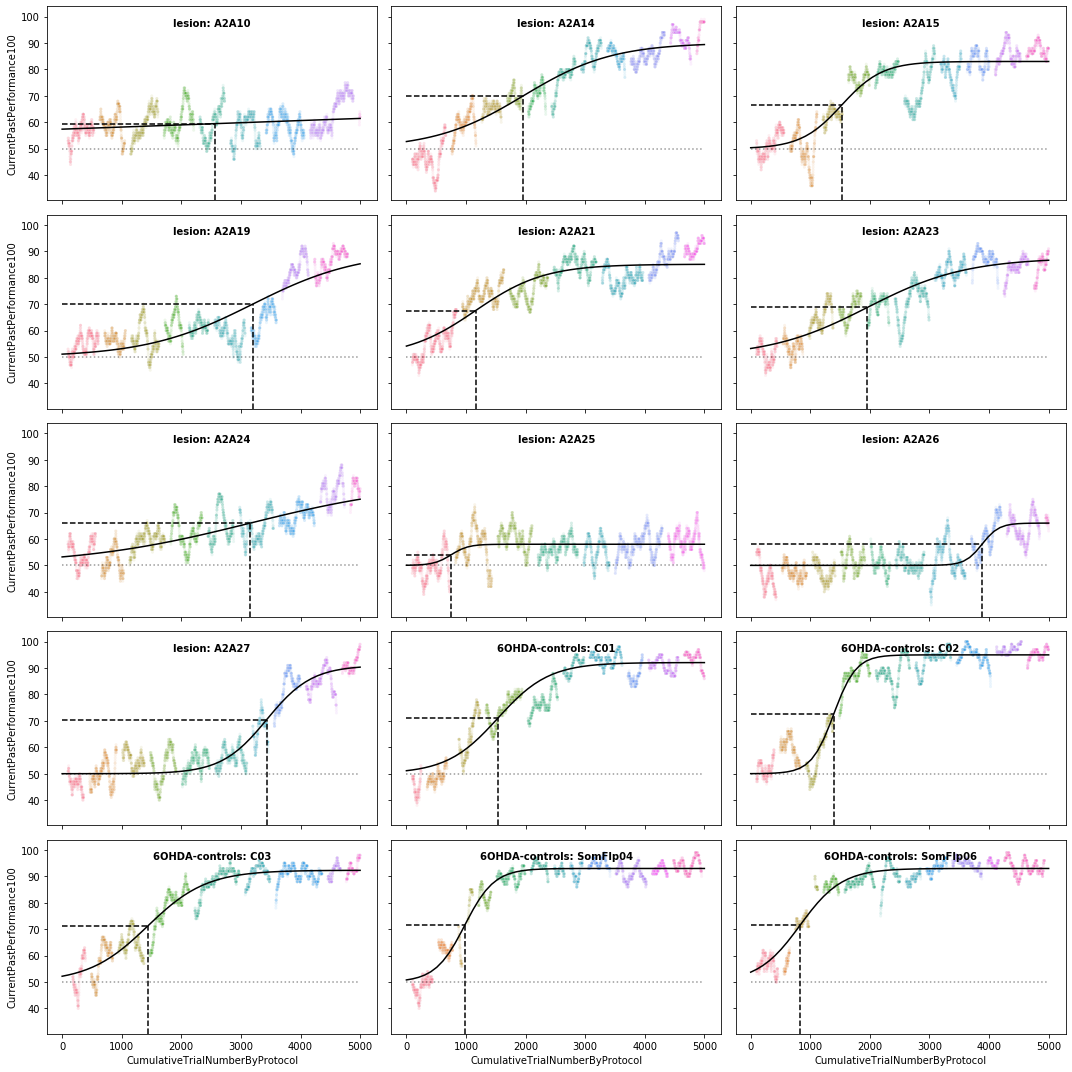

In [34]:
# plot the curves again pointing to the maximum
# sanity check to see that these scaled values recreate the curves

x = np.linspace(1,5000)

fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # plot here
    sns.scatterplot(data=df,
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    sns.lineplot(x=x,
                 y=sigmoid_func_sc(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='k',
                 ci=None,
                 ax=ax)
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.9, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)


# point to the maximum slope
ymin, ymax = plt.gca().get_ybound()
for counter, animal in enumerate(ans_list):
    ax = axs[counter] 
    perc_max_slope = sigmoid_func_sc(der_max_dir[animal][0],
                                     *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                       fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                       fit_df[fit_df.AnimalID==animal].bias.iloc[0]])
    ax.axvline(fit_df[fit_df.AnimalID==animal].bias.iloc[0], 0, (perc_max_slope - ymin) / (ymax - ymin), linestyle='--', color='k')
    ax.plot([0, fit_df[fit_df.AnimalID==animal].bias.iloc[0]], [perc_max_slope,perc_max_slope], 'k--')
    
update_progress(1)
plt.savefig(data_directory + 'Sigmoid_fitting.pdf', transparent=True, bbox_inches='tight')
clear_output()
plt.show(fig)

As a learning speed measure I use the point of the maximum learning rate, which is the maximum of the derivative of the fitting, which is also the middle point of the curve (in between 50% and maximum performance)
The bias indicates where this point lies in the x axis: at which trial number this point is reached

In [35]:
# add the maximum value of the derivative to the fit_df dataframe
for key, value in der_max_dir.items():
    fit_df.loc[fit_df.index[fit_df['AnimalID'] == key].tolist()[0], 'max_of_der'] = value[1]

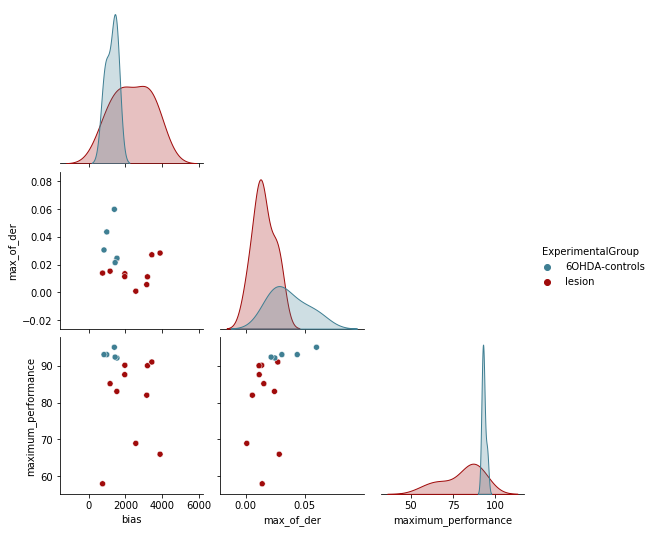

In [36]:
# Basic correlogram
g = sns.pairplot(fit_df,
                 vars=['bias', 'max_of_der', 'maximum_performance'],
                 hue='ExperimentalGroup', hue_order=hue_order, corner=True)#, kind='reg')
#g.axes[1,1].set_ylim(0.8 * np.min(fit_df.slope), 1.1 * np.max(fit_df.slope))
plt.savefig(data_directory + 'Correlogram_of_fits.pdf', transparent=True, bbox_inches='tight')
plt.show(g)

Basic correlogram of the fitting parameters

In [34]:
# merge this with the imaging data
image_analysis_results_file = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Histology_of_tail_lesions/6OHDA/summary_df_LS_Apr2020.csv'

In [35]:
# read csv file
iar = pd.read_csv(image_analysis_results_file)

In [36]:
# add these columns to the df for correlation comparison and subselect some
merged_df = pd.merge(left=fit_df, right=iar, how='left', left_on='AnimalID', right_on='mouse id')[
    ['AnimalID',
     'maximum_performance',
     'bias',
     'ExperimentalGroup',
     'max_of_der',
     'median_performance_reached_in_last_ntrials',
     'n trials to criterion',
     'max performance reached',
     'ratio posterior/anterior']
]

ValueError: Inputs must not be empty.

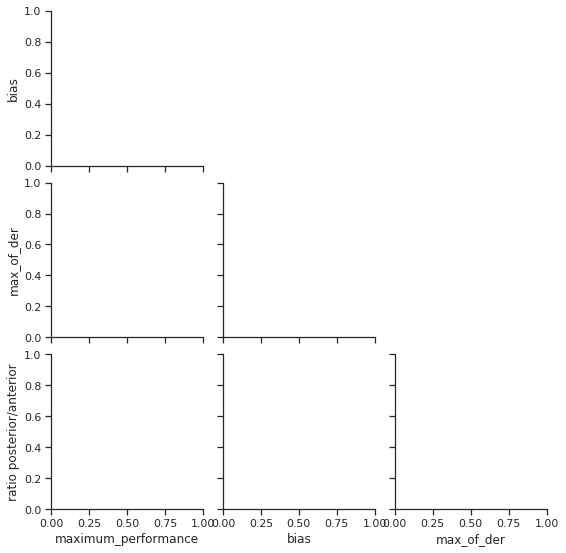

In [40]:
# Create an instance of the PairGrid class.
grid = sns.PairGrid(data= merged_df.dropna(),
                    vars = ['maximum_performance',
                            'bias',
                            'max_of_der',
                            #'n trials to criterion',
                            'ratio posterior/anterior'],
                    #size = 3,
                    hue = 'AnimalID')
# Map a scatter plot to the upper triangle
grid = grid.map_lower(plt.scatter)
for i, j in zip(*np.triu_indices_from(grid.axes, 0)):
    grid.axes[i, j].set_visible(False)
    
# calculate linear regressions and plot them
plot_utils.reg_in_ax(merged_df.dropna()['max_of_der'], merged_df.dropna()['ratio posterior/anterior'], grid.axes[3, 2], 'lower right')
plot_utils.reg_in_ax(merged_df.dropna()['bias'], merged_df.dropna()['ratio posterior/anterior'], grid.axes[3, 1], 'upper right')
plot_utils.reg_in_ax(merged_df.dropna()['maximum_performance'], merged_df.dropna()['ratio posterior/anterior'], grid.axes[3, 0], 'upper left') 

# correct axis limits
grid.axes[3, 2].set_xlim(0.8 * np.min(merged_df.dropna().max_of_der), 1.1 * np.max(merged_df.dropna().max_of_der))
grid.axes[2, 1].set_ylim(0.8 * np.min(merged_df.dropna().max_of_der), 1.1 * np.max(merged_df.dropna().max_of_der))
grid.add_legend()
plt.savefig(data_directory + 'Correlogram_with_lesion_size.pdf', transparent=True, bbox_inches='tight')
plt.show(grid)

Including the image analysis data to show the correlation with learning

In [39]:
# Select animals to remove from the study based on this
#ans_to_remove = ['SomFlp08']
ans_to_remove = []
df_sel = df_to_plot[~df_to_plot.AnimalID.isin(ans_to_remove)].copy()
fit_df_sel = fit_df[~fit_df.AnimalID.isin(ans_to_remove)].copy()
print('Animals removed from the following analysis based on this:', ans_to_remove)

Animals removed from the following analysis based on this: []


In [40]:
print('Differences of parameters between groups')

Differences of parameters between groups


In [41]:
# calculate significance
parameters_to_show = ['maximum_performance', 'max_of_der', 'bias']
# define three levels of significance for the plotting
sig_levels = [0.05, 0.01, 0.001]
pvals = []
print('Kluskal-Wallis tests on the parameters')
for var in parameters_to_show:
    kt = stats.kruskal(fit_df_sel[fit_df_sel.ExperimentalGroup==hue_order[0]][var].dropna(),
                  fit_df_sel[fit_df_sel.ExperimentalGroup==hue_order[1]][var].dropna())
    print(var + ':\t\tpvalue: ' + str(kt.pvalue) )
    pvals.append(kt.pvalue)

Kluskal-Wallis tests on the parameters
maximum_performance:		pvalue: 0.00219964706111306
max_of_der:		pvalue: 0.014305878435429641
bias:		pvalue: 0.050043521248705126


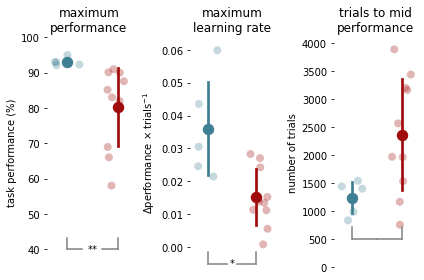

In [42]:
# compare the parameters between groups
titles = ['maximum\nperformance', 'maximum\nlearning rate', 'trials to mid\nperformance']
ylabs = ['task performance (%)', '\u0394performance \u00D7 trials$\mathregular{^{-1}}$', 'number of trials']

fig, axs = plt.subplots(ncols=3, nrows=1, sharey=False, figsize=(6,4))
axs = axs.ravel()
for i, var in enumerate(parameters_to_show):
    sns.pointplot(data=fit_df_sel,
                  x='ExperimentalGroup',
                  order=hue_order,
                  y=var,
                  hue='ExperimentalGroup',
                  hue_order=hue_order,
                  dodge=False, join=False,
                  markers="o", scale=1.3, ci='sd',
                  ax=axs[i])
    
    sns.stripplot(data=fit_df_sel,
                  x='ExperimentalGroup',
                  y=var,
                  order=hue_order,
                  hue='ExperimentalGroup',
                  hue_order=hue_order,
                  dodge=False, jitter=.25,
                  alpha=.3, zorder=1, size=8,
                  ax=axs[i])
    axs[i].set_title(titles[i])
    axs[i].set_ylabel(ylabs[i])

for ax in axs:
    #legend
    #handles, labels = ax.get_legend_handles_labels()
    #by_label = dict(zip(labels, handles))
    #ax.legend(by_label.values(), by_label.keys(), frameon=False)
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Only show ticks on the left
    #ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks([])
    ax.xaxis.set_visible(False)

# fix individual axis
# for 6OHDA
#axs[0].set_ylim(50, 100)
#axs[1].set_ylim(0, axs[1].get_ylim()[1])
#axs[2].set_ylim(0, axs[2].get_ylim()[1])
# for D1cre pre
axs[0].set_ylim(35, 100)
axs[1].set_ylim(-0.006, axs[1].get_ylim()[1])
axs[2].set_ylim(0, axs[2].get_ylim()[1])

axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[0].get_legend().remove()

# figure legend in the bottom
"""
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), frameon=False, loc=(.25,-0.01), ncol=2)
"""

# add statistics
# for 6OHDA
# yvals = [70, 0.003, 500]
# for D1 pre
yvals = [40, -0.005, 500]

for i,ax in enumerate(axs):
    n_ast = sum(pvals[i] < sig_levels)
    plot_utils.add_stats(ax, yval=yvals[i], n_asterisks=n_ast)    

plt.tight_layout()
plt.savefig(data_directory + 'Parameters_group_comparison.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [43]:
for i,s in enumerate(sig_levels):
    print(i+1, 'asterisks: pval <', s)

1 asterisks: pval < 0.05
2 asterisks: pval < 0.01
3 asterisks: pval < 0.001


In [44]:
# plot the correlation with the imaging
#merged_df_sel = merged_df[~merged_df.AnimalID.isin(ans_to_remove)].copy()
plt.figure(figsize=(5,3))
sns.scatterplot(data=merged_df[merged_df.ExperimentalGroup=='6OHDAtail'],
                x='maximum_performance',
                y='ratio posterior/anterior',
                color=LSpalette[1],
                s=100)
ax = plt.gca()
cntrls = merged_df[merged_df.ExperimentalGroup=='CortexBuffer'].copy()
ax.scatter(cntrls.maximum_performance.mean(),
         cntrls['ratio posterior/anterior'].mean(),
         marker = 'o', linewidth=3,
         s=100, facecolors='none', edgecolors=LSpalette[0])

# calculate regression with the 6OHDAs
df_for_reg = merged_df[merged_df.ExperimentalGroup=='6OHDAtail'].dropna().copy()
plot_utils.reg_in_ax(df_for_reg['maximum_performance'], df_for_reg['ratio posterior/anterior'], ax, 'upper left')
#ax.get_legend().remove()
ax.set_ylabel('posterior DA / anterior DA')
ax.set_xlabel('maximum performance (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(data_directory + 'lesion_maxperf_regression.pdf', transparent=True, bbox_inches='tight')
plt.show()

NameError: name 'merged_df' is not defined

<Figure size 360x216 with 0 Axes>

#### calculate the statistical differences of performances between groups at different points in learning time

Shaded area indicates std, and performance is calculated using CurrentPastPerformance100


/home/hernandom/.conda/envs/behav/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


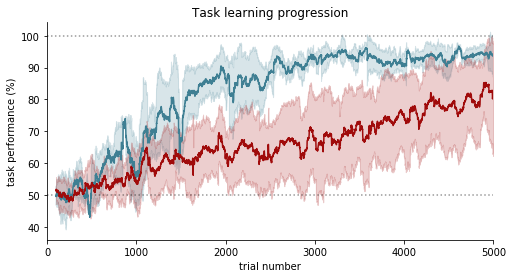

In [45]:
# create a publication-quality figure, grouping the data by the Experimental Group, and showing the continous monitoring
# of learning
col_to_plot = 'CurrentPastPerformance100'
data_mean = df_sel.groupby(['CumulativeTrialNumberByProtocol','ExperimentalGroup'])[col_to_plot].mean().reset_index()
st_err_mean = df_sel.groupby(['CumulativeTrialNumberByProtocol','ExperimentalGroup'])[col_to_plot].std().reset_index()
data_mean['low_bound'] = data_mean[col_to_plot] - st_err_mean[col_to_plot]
data_mean['high_bound'] = data_mean[col_to_plot] + st_err_mean[col_to_plot]

fig1 = plt.figure(figsize=(8, 4))
plt.axhline(50, ls='dotted', alpha=0.4, color='k')
plt.axhline(100, ls='dotted', alpha=0.4, color='k')
for i,eg in enumerate(hue_order):
    df = data_mean[data_mean.ExperimentalGroup==eg].copy()
    x = df.CumulativeTrialNumberByProtocol
    plt.plot(x, df[col_to_plot], color=LSpalette[i], label=eg)
    #plt.plot(data_mean[data_mean.ExperimentalGroup==eg][col_to_plot], linestyle='--', color=LSpalette[i], label='95% ci')
    #plt.plot(neg_ci, linestyle='--', color='k')
    y1 = df['low_bound']
    y2 = df['high_bound']
    plt.fill_between(x, y1, y2, where=y2 >= y1, color=LSpalette[i], alpha=.2, interpolate=False)

plt.ylabel(col_to_plot)
plt.xlabel('trial number')
plt.ylabel('task performance (%)')
plt.legend(loc=(0.76,0.3), frameon=False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# remove the legend as the figure has it's own
ax.get_legend().remove()

ax.set_xlim((0,5000))

plt.title('Task learning progression')

plt.savefig(data_directory + 'Performance_between_groups.pdf', transparent=True, bbox_inches='tight')
fig1.show()
print('Shaded area indicates std, and performance is calculated using', col_to_plot)

In [46]:
# define a 100-trial window to bin the data
xbin = 100
df_sel["TrialIndexBinned"] = (df_sel.CumulativeTrialNumberByProtocol // xbin) * xbin + xbin / 2
print('Trials are binned in groups of', xbin)

Trials are binned in groups of 100


In [47]:
# groupby so each animal has a mean of the performance in each bin
df_bintr = df_sel.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned','Protocol']).mean().reset_index()

In [48]:
# create a scaled version of the performance
df_bintr['Performance'] = df_bintr.FirstPokeCorrect * 100

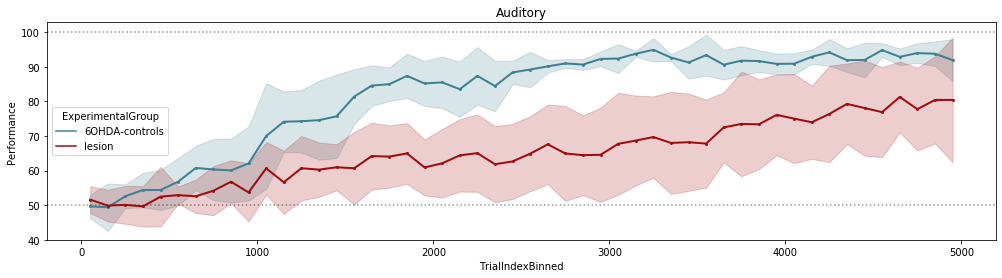

In [49]:
# plot the performance
fig, axs = plt.subplots(len(pd.unique(df_bintr['Protocol'])), 1, figsize=(17,4 * len(pd.unique(df_bintr['Protocol']))),
                        sharex=True)
if axs.numRows > 1:
    axs = axs.ravel()
else:
    axs = [axs,]
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='dotted', alpha=0.4, color='k')
    ax.axhline(100, ls='dotted', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(df_bintr['Protocol'])):
    sns.lineplot(x='TrialIndexBinned', y='Performance',
                 data=df_bintr[df_bintr['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup',
                 hue_order=hue_order,
                 marker=".", alpha=1,
                 markeredgewidth=0, linewidth=2,
                 ci='sd')
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=40)
    '''
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    '''
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(data_directory + 'Performance_grouped.pdf', transparent=True, bbox_inches='tight')
plt.show(fig)

In [50]:
# plot the differences of the means using the binned data
perdif_df = df_bintr[df_bintr.ExperimentalGroup == 'CortexBuffer'].groupby('TrialIndexBinned').mean()['Performance'] -\
df_bintr[df_bintr.ExperimentalGroup == '6OHDAtail'].groupby('TrialIndexBinned').mean()['Performance']
plt.figure(figsize=(16, 4))
sns.lineplot(data=perdif_df)
plt.show()
clear_output()

Now can measure the differences between the means of the two groups

#### Calculate the significance by resampling: suffle the group labels multiple times and calculate the likelihood of observing this data
References:

Supplementary figure 4 in here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562676/

See also methods here: https://www.biorxiv.org/content/10.1101/716274v3.full

In [51]:
# define a function to generate a list of experimental groups randomly
def generate_eg(list_size, prob, labs = hue_order):
    ltr = []
    for i in range(list_size):
        if random.random() < prob:
            ltr.append(labs[0])
        else:
            ltr.append(labs[1])
    return ltr

In [58]:
# select the important columns
df_colsel = df_bintr[['AnimalID', 'ExperimentalGroup', 'TrialIndexBinned', 'Performance']].copy()
# get the experimental group for each animal
exp_gr = [df_colsel[df_colsel.AnimalID==x].ExperimentalGroup.unique()[0] for x in df_colsel.AnimalID.unique()]
# get the number of mice
n_an = len(exp_gr)
# get the probability of a mouse to be a control for this dataset
cb_prob = sum([x==hue_order[0] for x in exp_gr]) / n_an
# set random seed
np.random.seed(124321)
# calculate the differences of means by resampling
shuff_res = []
nsh = 10000
for i in range(nsh):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.AnimalID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.AnimalID]
    # calculate the differences and append
    shuff_res.append(df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
                     df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance'])
    update_progress(i / nsh)
# save in a data frame format
shrdf = pd.concat(shuff_res)
update_progress(1)
clear_output()

In [59]:
real_data = df_colsel[df_colsel.ExperimentalGroup == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
            df_colsel[df_colsel.ExperimentalGroup == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']

The shuffling respects the proportion of mice in every group.

In [60]:
print('Data is shuffled', nsh, 'times')

Data is shuffled 10000 times


/home/hernandom/.conda/envs/behav/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


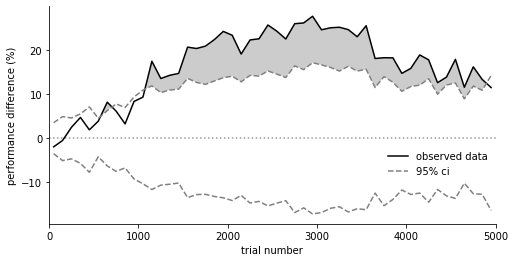

In [61]:
#plot
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

fig2 = plt.figure(figsize=(8, 4))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(real_data, color='k', label='observed data')
plt.plot(pos_ci, linestyle='--', color='gray', label='95% ci')
plt.plot(neg_ci, linestyle='--', color='gray')
x = pos_ci.reset_index().TrialIndexBinned
y1 = pos_ci.reset_index().Performance
y2 = real_data.reset_index().Performance
plt.fill_between(x, y1, y2, where=y2 >= y1, facecolor='k', alpha=.2, interpolate=True)
plt.ylabel('performance difference (%)')
plt.xlabel('trial number')
plt.legend(loc=(0.75,0.2), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0,5000))

plt.savefig(data_directory + 'Differences_of_means_significance_by_trial_bins.pdf',transparent=True, bbox_inches='tight')
fig2.show()

The red line shows the difference between the means in terms of performance.
The dotted lines show 95% confidence intervals for shuffled data.

This shows how likely is that each point crosses the line (point-base significance).

###### Substitute of the mixed anova: find the likelihood of any point being significant. Shuffle more data and quantify the percentage of times there is a crossing. Generate global bands of confidence

In [62]:
quants_to_test = [0.99, 0.995, 0.996, 0.997, 0.998, 0.999, 0.9999]
nsh=1000
# create an empty array to store results
global_sig = np.empty((nsh, len(quants_to_test)), dtype=bool)
# loop over shuffle data
for i in range(nsh):
    # shuffle the list of groups by assigning a probability for each mouse to be in a group based on the real ratio
    exp_grs = generate_eg(n_an, cb_prob)
    # create a diccionary
    egs_dict = dict(zip(df_colsel.AnimalID.unique(), exp_grs))
    # create a new column with the shuffled group
    df_colsel['egs'] = [egs_dict[x] for x in df_colsel.AnimalID]
    # calculate the differences
    sh_dif = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean()['Performance'] -\
                     df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean()['Performance']
    # for each quantile band, what percentages of lines cross at any point
    for k,q in enumerate(quants_to_test):
        global_sig[i,k] = any(np.logical_or(sh_dif > shrdf.groupby('TrialIndexBinned').quantile(q),
                                            sh_dif < shrdf.groupby('TrialIndexBinned').quantile(1 - q)))
        
    update_progress(i / nsh)
clear_output()

In [63]:
print('New shuffled data,', nsh, 'times')

New shuffled data, 1000 times


ci =  0.99 	global pval =  0.25 	real data significant  True
ci =  0.995 	global pval =  0.145 	real data significant  True
ci =  0.996 	global pval =  0.117 	real data significant  True
ci =  0.997 	global pval =  0.085 	real data significant  True
ci =  0.998 	global pval =  0.067 	real data significant  True
ci =  0.999 	global pval =  0.035 	real data significant  True
ci =  0.9999 	global pval =  0.002 	real data significant  True


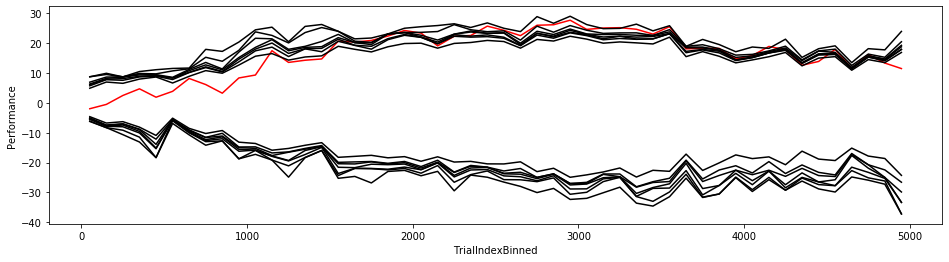

In [64]:
# plot the confidence intervals and print their global p-values:
plt.figure(figsize=(16, 4))
sns.lineplot(data=real_data, color='r')
for k,q in enumerate(quants_to_test):
    sns.lineplot(data=shrdf.groupby('TrialIndexBinned').quantile(q), color='k')
    sns.lineplot(data=shrdf.groupby('TrialIndexBinned').quantile((1 - q)), color='k')
    print('ci = ', q,
          '\tglobal pval = ',  np.sum(global_sig, axis=0)[k] / nsh,
          '\treal data significant ', any(np.logical_or(real_data > shrdf.groupby('TrialIndexBinned').quantile(q),
                                            real_data < shrdf.groupby('TrialIndexBinned').quantile(1 - q))))
plt.show()

##### Perform a mixed anova to find if the two datasets differ globally

In [65]:
df_to_plot.columns

Index(['AnimalID', 'BiasCorrection', 'CenterPortDuration', 'Contingency',
       'CumulativePerformance', 'ExperimentalGroup', 'FirstPoke',
       'FirstPokeCorrect', 'FullGUI', 'FullSessionTime', 'Muscimol',
       'OptoStim', 'Outcomes', 'PreviousChoice', 'Protocol', 'Punish',
       'PunishDelay', 'ResponseTime', 'RewardAmount', 'RewardChange',
       'RewardChangeBlock', 'SessionTime', 'Stimulation', 'SwitchSide',
       'TrialEvents', 'TrialHighPerc', 'TrialIndex', 'TrialSequence',
       'TrialSide', 'TrialStartTimestamp', 'TrialStates', 'SessionID',
       'CumulativeTrialNumber', 'CumulativeTrialNumberByProtocol',
       'CurrentPastPerformance20', 'CurrentPastPerformance100',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime', 'RightBias',
       'TrialsSpeed', 'PrevTrialSuccess', 'TrialIndexBinned200'],
      dtype='object')

In [66]:
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200']).median().reset_index()[[
    'AnimalID','ExperimentalGroup','TrialIndexBinned200','CumulativePerformance','CurrentPastPerformance100']]

In [67]:
# transform trial bins to int
df_colsel.TrialIndexBinned = df_colsel.TrialIndexBinned.astype(int)#.astype(str)

In [68]:
# remove the 5000 bin as is has one Nan
df_colsel = df_colsel[~ (df_colsel.TrialIndexBinned == 5000)]

In [69]:
aov = pg.mixed_anova(dv='Performance', within='TrialIndexBinned',
                     subject='AnimalID', between='ExperimentalGroup', data=df_colsel)
print(aov)

              Source            SS  DF1  DF2            MS          F  \
0  ExperimentalGroup  45362.197788    1   13  45362.197788  20.623622   
1   TrialIndexBinned  79796.847012   49  637   1628.507082  32.743669   
2        Interaction  10032.737242   49  637    204.749740   4.116812   

           p-unc       np2       eps  
0   5.538416e-04  0.613367       NaN  
1  4.806938e-142  0.715808  0.084151  
2   4.181437e-17  0.240513       NaN  


It is indeed also significant

In [3]:
# save the workspace
dill.dump_session(data_directory + DS_name + '.db')

# transform to a report using this:
convertion_string = 'jupyter nbconvert --to html --no-input '+\
                os.path.join(os.path.abspath(''), 'Statistical_Analysis_between_two_groups.ipynb') +\
                ' --output ' + data_directory + DS_name + '.html'
os.system(convertion_string)
clear_output()

NameError: name 'data_directory' is not defined

### Stay-switch strategy

In [102]:
PAST_WINDOW = 20
BIN_TRIALS = 50

# create an empty df_list to append dfs
ss_df_list = []
for animal_id in np.unique(df_to_plot.AnimalID):
    # Select an animal
    ss_animal_df = df_to_plot[df_to_plot.AnimalID == animal_id]
    # Select only stay/switch trials
    for switch, ss_text in zip([0, 1], ['stay', 'swith']):
        ss_df = ss_animal_df[ss_animal_df.SwitchSide == switch].copy()
        # Calculate performance of the past X trials
        CumPerList = []
        for Sid in pd.unique(ss_df['SessionID']):
            CumPerList.append(cuf.perf_window_calculator(ss_df[ss_df['SessionID']==Sid], PAST_WINDOW))
        # flatten the list of lists
        ss_df['CurrentPastPerformance20_ss'] = np.array(list(chain(*[x for x in CumPerList])))
        # recalculate CumulativeTrialNumber
        ss_df['CumulativeTrialNumber_ss'] = np.arange(len(ss_df))
        # groupby to binarize every 50 trials
        ss_df["TrialIndexBinned_ss"] = (ss_df.CumulativeTrialNumber_ss // BIN_TRIALS) * BIN_TRIALS + BIN_TRIALS / 2
        # save as a separate df
        ss_df_bintr = ss_df.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned_ss']).mean().reset_index()
        # append to general
        ss_df_list.append(ss_df_bintr)
# merge as one df
ss_df = pd.concat(ss_df_list, ignore_index=True)

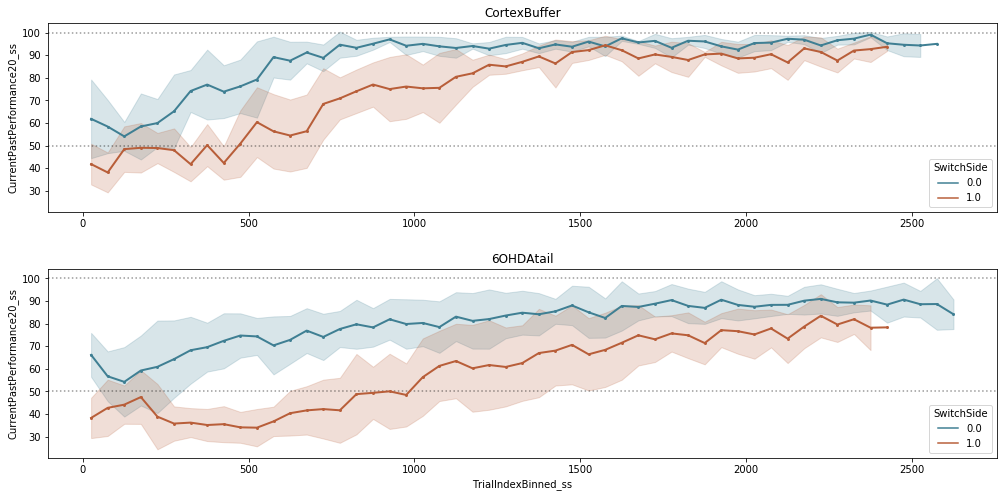

In [103]:
# plot the performance
fig, axs = plt.subplots(len(pd.unique(ss_df['ExperimentalGroup'])), 1, figsize=(17,4 * len(pd.unique(ss_df['ExperimentalGroup']))),
                        sharex=True, sharey=True)
if len(axs) > 1:
    axs = axs.ravel()
else:
    axs = [axs,]
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='dotted', alpha=0.4, color='k')
    ax.axhline(100, ls='dotted', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(ss_df['ExperimentalGroup'])):
    sns.lineplot(x='TrialIndexBinned_ss', y='CurrentPastPerformance20_ss',
                 data=ss_df[ss_df['ExperimentalGroup']==prot],
                 ax=axs[ax], hue='SwitchSide',
                 #hue_order=hue_order,
                 marker=".", alpha=1,
                 markeredgewidth=0, linewidth=2,
                 ci='sd')
                
    axs[ax].set_title(prot)
    #axs[ax].set_ylim(bottom=40)

for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(data_directory + 'Switch_stay.pdf', transparent=True, bbox_inches='tight')
plt.show(fig)

In [ ]:
### DEPRECATED:

In [ ]:
##### another way, less proper I think, to get to when the two groups differ, is to do multiple tests, and correct for multiple tests

In [ ]:
# another way is to DO THIS BY SESSION

In [ ]:
tr_to_show = [200, 600, 1000, 1400, 2000, 3000, 4000, 4800]
df_st = df_bin200tr[df_bin200tr.TrialIndexBinned200.isin(tr_to_show)]
df_st = df_bin200tr
plt.figure(figsize=(16, 6))

# add mean and sd
sns.pointplot(data=df_st,
              x='TrialIndexBinned200',
              y='CurrentPastPerformance100',
              hue='ExperimentalGroup',
              dodge=.4, join=False,
              markers="o", scale=1.3, ci='sd')

sns.stripplot(data=df_st,
            x='TrialIndexBinned200',
            y='CurrentPastPerformance100',
            hue='ExperimentalGroup',
            dodge=True, jitter=.15,
            alpha=.3, zorder=1, size=8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [ ]:
# perform the tests
pvals = []
trial_bin = []
for index, group in df_st.groupby('TrialIndexBinned200'):
    kt = stats.kruskal(group[group.ExperimentalGroup=='CortexBuffer'].CurrentPastPerformance100,
              group[group.ExperimentalGroup=='6OHDAtail'].CurrentPastPerformance100)
    print('Trial: ' + str(index) + '\t\tpvalue: ' + str(kt.pvalue) )
    pvals.append(kt.pvalue)
    trial_bin.append(index)

In [ ]:
# perform the correction:
from statsmodels.stats.multitest import multipletests as mtpt
corrected_pvals = mtpt(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pvals

In [ ]:
# redo the plot with the significance
plt.figure(figsize=(16, 6))

# add mean and sd
sns.pointplot(data=df_st,
              x='TrialIndexBinned200',
              y='CurrentPastPerformance100',
              hue='ExperimentalGroup',
              dodge=.4, join=False,
              markers="o", scale=1.3, ci='sd')

sns.stripplot(data=df_st,
            x='TrialIndexBinned200',
            y='CurrentPastPerformance100',
            hue='ExperimentalGroup',
            dodge=True, jitter=.15,
            alpha=.3, zorder=1, size=8)

# make stars for those significant
sig_x = np.transpose([i for i,x in enumerate(list(corrected_pvals[0])) if x])
y_points = np.transpose([100] * len(sig_x))
plt.gca().plot(sig_x, y_points, 'kx')
plt.gca().plot(sig_x, y_points, 'k+')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [ ]:
dset = pd.DataFrame({'idx': np.repeat(np.arange(3), 100000), 'values': np.random.randn(300000), 'groups': np.arange(300000) % 2})
print(dset)
st = time.time()
dset.groupby('idx').apply(lambda x: x.loc[x.groups == 0, 'values'].mean() - x.loc[x.groups == 1, 'values'].mean())
print(time.time() - st)

In [ ]:
dset = pd.DataFrame({'idx': np.repeat(np.arange(3), 100000), 'values': np.random.randn(300000), 'groups': np.arange(300000) % 2})
print(dset)
st = time.time()
dset[dset.groups==0].groupby('idx').mean()['values'] - dset[dset.groups==1].groupby('idx').mean()['values']
#dset.groupby('idx').apply(lambda x: x.loc[x.groups == 0, 'values'].mean() - x.loc[x.groups == 1, 'values'].mean())
print(time.time() - st)

In [ ]:
# test how this looks for each cohort
ans_in_first_cohort = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']

column_to_plot = 'CurrentPastPerformance100'

fig, axs = plt.subplots(2, 1, figsize=(17, 14), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
             data=df_bintr[df_bintr.AnimalID.isin(ans_in_first_cohort)],
             ax=axs[0], hue='ExperimentalGroup',
             hue_order=['CortexBuffer', '6OHDAtail'],
             marker=".", alpha=1,
             markeredgewidth=0, linewidth=2,
             ci='sd', n_boot=10000)
             
axs[0].set_title('First Cohort')
axs[0].set_ylim(bottom=40)

sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
             data=df_bintr[~df_bintr.AnimalID.isin(ans_in_first_cohort)],
             ax=axs[1], hue='ExperimentalGroup',
             hue_order=['CortexBuffer', '6OHDAtail'],
             marker=".", alpha=1,
             markeredgewidth=0, linewidth=2,
             ci='sd', n_boot=10000)
             
axs[1].set_title('Second Cohort')
axs[1].set_ylim(bottom=40)

for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

plt.show()

In [ ]:
df_to_plot[df_to_plot.AnimalID=='C01'].dtypes

In [ ]:
# Optional post-hoc tests
pg.pairwise_ttests(dv='CurrentPastPerformance100', between='ExperimentalGroup',
                   within='TrialIndexBinned200', subject='AnimalID', data=df_bin200tr,
                   alpha=0.05,
                   padjust='holm',
                   parametric=False)

In [ ]:
pg.plot_paired(dv='CurrentPastPerformance100', within='ExperimentalGroup',
                   subject='TrialIndexBinned200', data=df_bin200tr)